# Bước 5: So sánh Apriori vs FP-Growth

Mục tiêu:

- Chạy Apriori và FP-Growth trên cùng một `basket_bool`
- So sánh:
  - Thời gian chạy
  - Số lượng tập mục phổ biến (frequent itemsets)
  - Số lượng luật kết hợp sinh ra
  - Độ dài trung bình của itemset
- Minh hoạ bằng biểu đồ để sinh viên thấy rõ trade-off giữa:
  - Độ đầy đủ của luật
  - Thời gian tính toán
  - Tính phù hợp với dữ liệu lớn


In [1]:
# PARAMETERS (for papermill)

BASKET_BOOL_PATH = "data/processed/basket_bool.parquet"

# Dùng chung tham số với hai thuật toán
MIN_SUPPORT = 0.01
MAX_LEN = 3
METRIC = "lift"
MIN_THRESHOLD = 1.0


In [2]:
# Parameters
BASKET_BOOL_PATH = "data/processed/basket_bool.parquet"
MIN_SUPPORT = 0.02
MAX_LEN = 3
METRIC = "lift"
MIN_THRESHOLD = 1.0


## Set up

In [3]:
%load_ext autoreload
%autoreload 2

import os
import sys

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Determine correct project root
cwd = os.getcwd()
if os.path.basename(cwd) == "notebooks":
    project_root = os.path.abspath("..")
else:
    project_root = cwd

src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.append(src_path)

from cluster_library import (
    benchmark_apriori_vs_fpgrowth,
    AssociationRulesMiner,
    FPGrowthMiner,
    DataVisualizer,
)

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12


## Tải basket_bool

In [4]:
basket_bool = pd.read_parquet(BASKET_BOOL_PATH)

print("=== Thông tin basket_bool ===")
print(f"- Số hoá đơn (rows): {basket_bool.shape[0]:,}")
print(f"- Số sản phẩm (columns): {basket_bool.shape[1]:,}")
print(f"- Tỷ lệ ô = 1 (có mua): {basket_bool.values.mean():.4f}")


=== Thông tin basket_bool ===
- Số hoá đơn (rows): 18,021
- Số sản phẩm (columns): 4,007
- Tỷ lệ ô = 1 (có mua): 0.0066


## Chạy benchmark

In [5]:
result = benchmark_apriori_vs_fpgrowth(
    basket_bool=basket_bool,
    min_support=MIN_SUPPORT,
    max_len=MAX_LEN,
    metric=METRIC,
    min_threshold=MIN_THRESHOLD,
)

summary = result["summary"]
summary


,algorithm,runtime_sec,n_itemsets,n_rules,avg_itemset_length
0,apriori,1.859914,400,218,1.2625
1,fpgrowth,6.920422,400,218,1.2625


## Biểu đồ so sánh thời gian

C:\Users\Admin\anaconda3\envs\shopping_env\lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\shopping_env\lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\shopping_env\lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


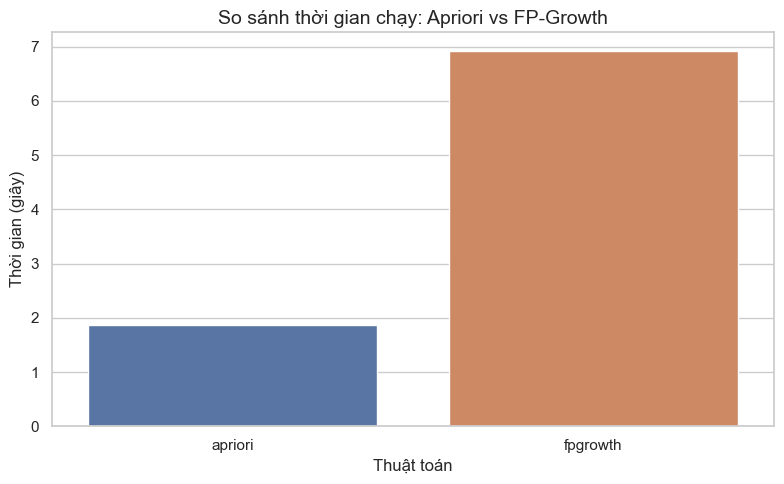

In [6]:
plt.figure()
sns.barplot(data=summary, x="algorithm", y="runtime_sec")
plt.title("So sánh thời gian chạy: Apriori vs FP-Growth")
plt.ylabel("Thời gian (giây)")
plt.xlabel("Thuật toán")
plt.tight_layout()
plt.show()


## Biểu đồ số lượng itemsets & rules

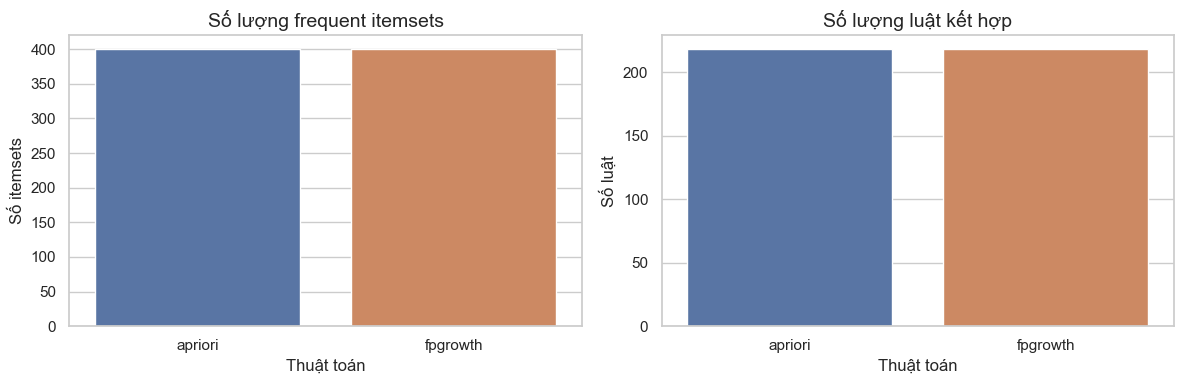

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.barplot(data=summary, x="algorithm", y="n_itemsets", ax=axes[0])
axes[0].set_title("Số lượng frequent itemsets")
axes[0].set_xlabel("Thuật toán")
axes[0].set_ylabel("Số itemsets")

sns.barplot(data=summary, x="algorithm", y="n_rules", ax=axes[1])
axes[1].set_title("Số lượng luật kết hợp")
axes[1].set_xlabel("Thuật toán")
axes[1].set_ylabel("Số luật")

plt.tight_layout()
plt.show()


## Độ dài trung bình iemset

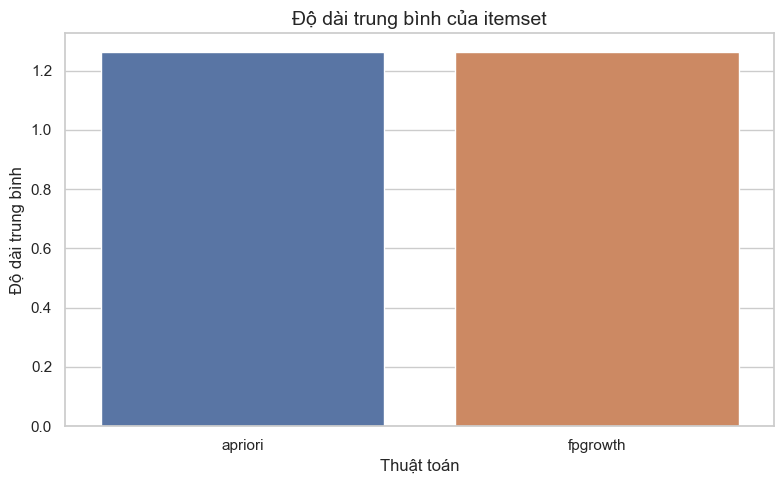

In [8]:
plt.figure()
sns.barplot(data=summary, x="algorithm", y="avg_itemset_length")
plt.title("Độ dài trung bình của itemset")
plt.xlabel("Thuật toán")
plt.ylabel("Độ dài trung bình")
plt.tight_layout()
plt.show()


## Một vài luật tiêu biểu từ mỗi thuật toán

In [9]:
cols_preview = [
    "antecedents_str",
    "consequents_str",
    "support",
    "confidence",
    "lift",
]

ap_rules = result["apriori_rules"].copy()
fp_rules = result["fpgrowth_rules"].copy()

# Thêm dạng chuỗi dễ đọc nếu chưa có (tuỳ trường hợp gọi)
if "antecedents_str" not in ap_rules.columns:
    miner_ap_tmp = AssociationRulesMiner(basket_bool=basket_bool)
    miner_ap_tmp.frequent_itemsets = result["apriori_itemsets"]
    miner_ap_tmp.rules = ap_rules
    ap_rules = miner_ap_tmp.add_readable_rule_str()

if "antecedents_str" not in fp_rules.columns:
    miner_fp_tmp = FPGrowthMiner(basket_bool=basket_bool)
    miner_fp_tmp.frequent_itemsets = result["fpgrowth_itemsets"]
    miner_fp_tmp.rules = fp_rules
    fp_rules = miner_fp_tmp.add_readable_rule_str()

print("=== Top 10 luật Apriori (theo lift) ===")
display(
    ap_rules.sort_values("lift", ascending=False)[cols_preview].head(10)
)

print("=== Top 10 luật FP-Growth (theo lift) ===")
display(
    fp_rules.sort_values("lift", ascending=False)[cols_preview].head(10)
)


=== Top 10 luật Apriori (theo lift) ===


,antecedents_str,consequents_str,support,confidence,lift
188,WOODEN HEART CHRISTMAS SCANDINAVIAN,WOODEN STAR CHRISTMAS SCANDINAVIAN,0.020421,0.722986,27.200282
189,WOODEN STAR CHRISTMAS SCANDINAVIAN,WOODEN HEART CHRISTMAS SCANDINAVIAN,0.020421,0.768267,27.200282
48,"GREEN REGENCY TEACUP AND SAUCER, ROSES REGENCY...",PINK REGENCY TEACUP AND SAUCER,0.027301,0.702857,18.043004
53,PINK REGENCY TEACUP AND SAUCER,"GREEN REGENCY TEACUP AND SAUCER, ROSES REGENCY...",0.027301,0.700855,18.043004
49,"PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY ...",GREEN REGENCY TEACUP AND SAUCER,0.027301,0.902752,17.455471
52,GREEN REGENCY TEACUP AND SAUCER,"PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY ...",0.027301,0.527897,17.455471
51,ROSES REGENCY TEACUP AND SAUCER,"GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY ...",0.027301,0.514644,16.101399
50,"GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY ...",ROSES REGENCY TEACUP AND SAUCER,0.027301,0.854167,16.101399
10,GREEN REGENCY TEACUP AND SAUCER,PINK REGENCY TEACUP AND SAUCER,0.031963,0.618026,15.865302
11,PINK REGENCY TEACUP AND SAUCER,GREEN REGENCY TEACUP AND SAUCER,0.031963,0.820513,15.865302


=== Top 10 luật FP-Growth (theo lift) ===


,antecedents_str,consequents_str,support,confidence,lift
188,WOODEN HEART CHRISTMAS SCANDINAVIAN,WOODEN STAR CHRISTMAS SCANDINAVIAN,0.020421,0.722986,27.200282
189,WOODEN STAR CHRISTMAS SCANDINAVIAN,WOODEN HEART CHRISTMAS SCANDINAVIAN,0.020421,0.768267,27.200282
48,"GREEN REGENCY TEACUP AND SAUCER, ROSES REGENCY...",PINK REGENCY TEACUP AND SAUCER,0.027301,0.702857,18.043004
53,PINK REGENCY TEACUP AND SAUCER,"GREEN REGENCY TEACUP AND SAUCER, ROSES REGENCY...",0.027301,0.700855,18.043004
49,"PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY ...",GREEN REGENCY TEACUP AND SAUCER,0.027301,0.902752,17.455471
52,GREEN REGENCY TEACUP AND SAUCER,"PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY ...",0.027301,0.527897,17.455471
51,ROSES REGENCY TEACUP AND SAUCER,"GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY ...",0.027301,0.514644,16.101399
50,"GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY ...",ROSES REGENCY TEACUP AND SAUCER,0.027301,0.854167,16.101399
10,GREEN REGENCY TEACUP AND SAUCER,PINK REGENCY TEACUP AND SAUCER,0.031963,0.618026,15.865302
11,PINK REGENCY TEACUP AND SAUCER,GREEN REGENCY TEACUP AND SAUCER,0.031963,0.820513,15.865302
